In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from new_train import train_nis
from new_train import train_nisp_rnis
from nis_net import NISNet
from nis_net import NISPNet
from nis_net import RNISNet
from datetime import datetime
from new_kuramoto import KuramotoModel
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

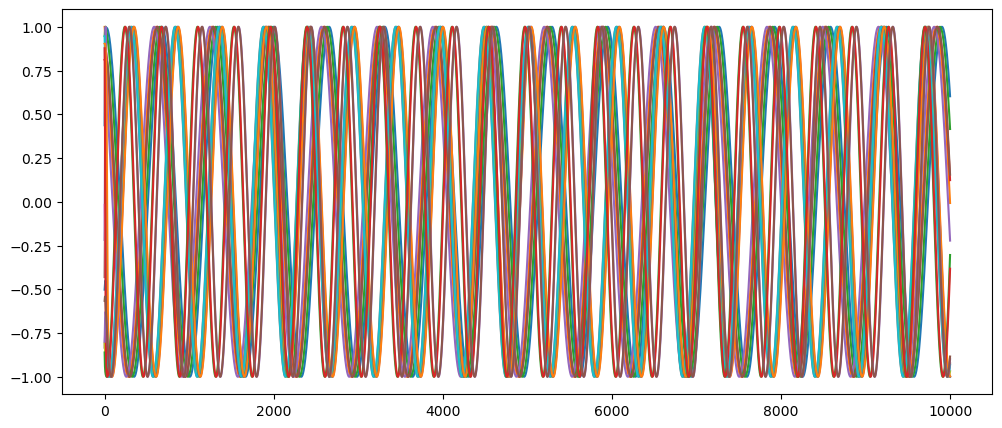

In [3]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

kura_train = KuramotoModel(steps=10000, dt=0.01, sz=18, groups=3, coupling=0.5)
timeserie, timeserie_next, _, _ = kura_train.simulate_oneserie(sample_step=5)

plt.figure(figsize=(12,5))
for i in range(16):
    plt.plot(timeserie[:,i])
plt.show()

In [4]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

kur_train = KuramotoModel(steps=10000, dt=0.01, sz=18, groups=2, coupling=0.5, sample_step=5)
kur_test = KuramotoModel(steps=1000, dt=0.01, sz=18, groups=3, coupling=0.5, sample_step=5)
train_data = [torch.FloatTensor(kur_train.input).to(device), torch.FloatTensor(kur_train.output).to(device)]
test_data = [torch.FloatTensor(kur_test.input).to(device), torch.FloatTensor(kur_test.output).to(device)]

# Train

In [5]:
# train params

T_total = 20001
clip = 500
sz = 18
scale = 2
hidden_units = 64
batch_size = 128
mae2_w = 3

# RNIS

In [6]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_rnis = RNISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=32,
                        is_normalized=True)
trainer = train_nisp_rnis(net=net_rnis, data=train_data, data_test=test_data, device=device)
trainer.training(T1=3000, T_all=T_total, mae2_w=mae2_w, batch_size=batch_size, clip=clip)
eis_rnis, term1s_rnis, term2s_rnis, losses_rnis, MAEs_mstep_rnis = trainer.return_log()
param_counts_rnis = trainer.param_counts

check point------step-> 13:51:02.979446; lasting 0:00:35.785437 seconds
Epoch: 0
Train loss: 0.0018
Test loss: 0.8788
dEI: 0.3136
term1: -0.6846
term2: 1.3118
------------------------------------------------------------------------------------------------------------------------
check point------step-> 13:51:20.795815; lasting 0:00:17.816369 seconds
Epoch: 500
Train loss: 0.5554
Test loss: 0.6580
dEI: 0.6149
term1: -0.2552
term2: 1.4850
------------------------------------------------------------------------------------------------------------------------
check point------step-> 13:51:38.893620; lasting 0:00:18.097805 seconds
Epoch: 1000
Train loss: 0.4016
Test loss: 0.6472
dEI: 0.4745
term1: -0.5487
term2: 1.4977
------------------------------------------------------------------------------------------------------------------------
check point------step-> 13:51:56.855872; lasting 0:00:17.962252 seconds
Epoch: 1500
Train loss: 0.3978
Test loss: 0.6501
dEI: 0.4124
term1: -0.6713
term2: 

# NIS

In [7]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_nis = NISNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, is_normalized=True)
trainer = train_nis(net=net_nis, data=train_data, data_test=test_data, device=device)
trainer.training(T_all=T_total, batch_size=batch_size, clip=clip)
eis_nis, term1s_nis, term2s_nis, losses_nis, MAEs_mstep_nis = trainer.return_log()
param_counts_nis = trainer.param_counts

check point------step-> 14:06:56.241998; lasting 0:00:06.492817 seconds
Epoch: 0
Train loss: 0.0018
Test loss: 0.9060
dEI: 0.4340
term1: -0.5264
term2: 1.3945
------------------------------------------------------------------------------------------------------------------------
check point------step-> 14:07:11.448682; lasting 0:00:15.206684 seconds
Epoch: 500
Train loss: 0.5762
Test loss: 0.6654
dEI: 0.6490
term1: -0.2780
term2: 1.5760
------------------------------------------------------------------------------------------------------------------------
check point------step-> 14:07:26.677782; lasting 0:00:15.229100 seconds
Epoch: 1000
Train loss: 0.4039
Test loss: 0.6506
dEI: 0.4922
term1: -0.5971
term2: 1.5814
------------------------------------------------------------------------------------------------------------------------
check point------step-> 14:07:41.864706; lasting 0:00:15.186924 seconds
Epoch: 1500
Train loss: 0.3987
Test loss: 0.6519
dEI: 0.4771
term1: -0.6256
term2: 

# NIS+

In [8]:
seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
net_nisp = NISPNet(input_size=sz, latent_size=scale, output_size=sz, 
                        hidden_units=hidden_units, hidden_units_dyn=hidden_units,
                        is_normalized=True)
trainer = train_nisp_rnis(net=net_nisp, data=train_data, data_test=test_data, device=device)
trainer.training(T1=3000, T_all=T_total, mae2_w=mae2_w, batch_size=batch_size, clip=clip)
eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp = trainer.return_log()
param_counts_nisp = trainer.param_counts

check point------step-> 14:17:03.258738; lasting 0:00:01.764577 seconds
Epoch: 0
Train loss: 0.0018
Test loss: 0.9060
dEI: 0.4340
term1: -0.5264
term2: 1.3945
------------------------------------------------------------------------------------------------------------------------
check point------step-> 14:17:18.528150; lasting 0:00:15.269412 seconds
Epoch: 500
Train loss: 0.5762
Test loss: 0.6654
dEI: 0.6490
term1: -0.2780
term2: 1.5760
------------------------------------------------------------------------------------------------------------------------
check point------step-> 14:17:33.809876; lasting 0:00:15.281726 seconds
Epoch: 1000
Train loss: 0.4039
Test loss: 0.6506
dEI: 0.4922
term1: -0.5971
term2: 1.5814
------------------------------------------------------------------------------------------------------------------------
check point------step-> 14:17:49.035041; lasting 0:00:15.225165 seconds
Epoch: 1500
Train loss: 0.3987
Test loss: 0.6519
dEI: 0.4771
term1: -0.6256
term2: 

# Result

In [9]:
print(param_counts_nis, param_counts_nisp, param_counts_rnis)

43758 48240 44148


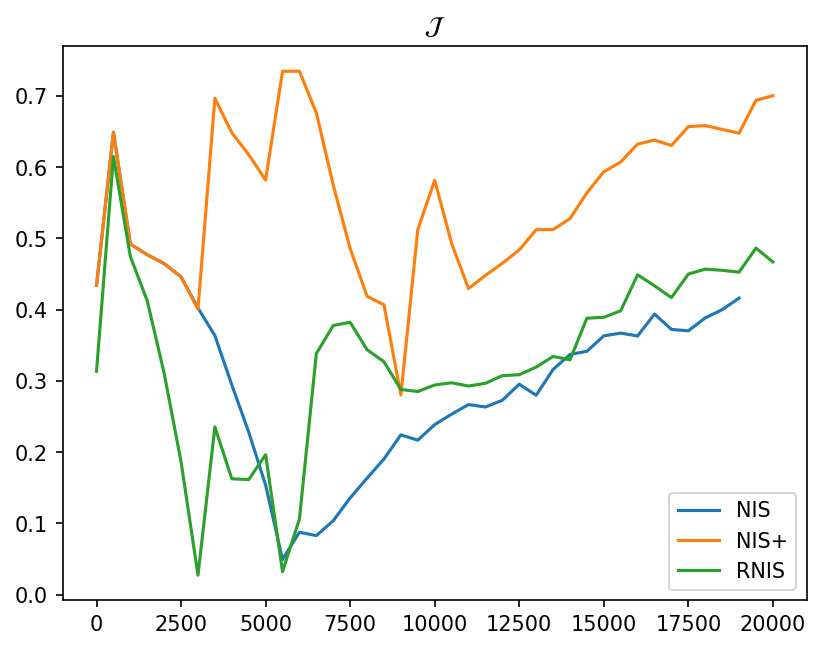

In [10]:
plt.figure(dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, eis_nis, label='NIS')
timeseries = np.arange(len(eis_nisp)) * clip
plt.plot(timeseries, eis_nisp, label='NIS+')
timeseries = np.arange(len(eis_rnis)) * clip
plt.plot(timeseries, eis_rnis, label='RNIS')
plt.title(r'$\mathcal{J}$')
plt.legend()
plt.show()

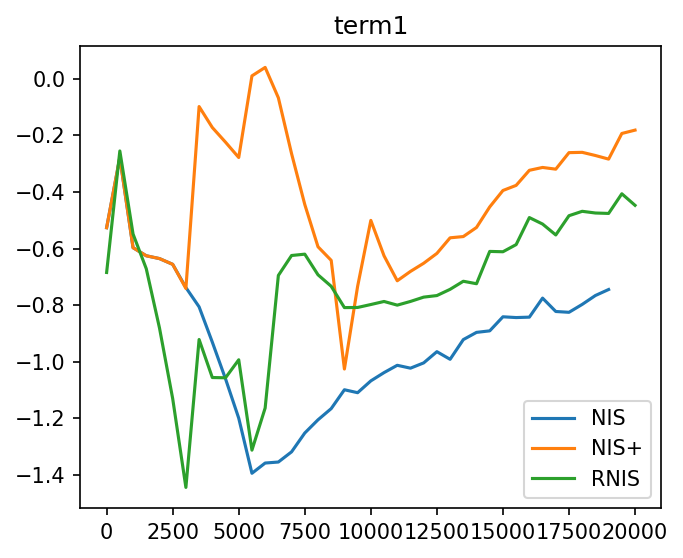

In [11]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, term1s_nis, label='NIS')
timeseries = np.arange(len(term1s_nisp)) * clip
plt.plot(timeseries, term1s_nisp, label='NIS+')
timeseries = np.arange(len(term1s_rnis)) * clip
plt.plot(timeseries, term1s_rnis, label='RNIS')
plt.title(r'term1')
plt.legend()
# plt.yscale('log')
plt.show()

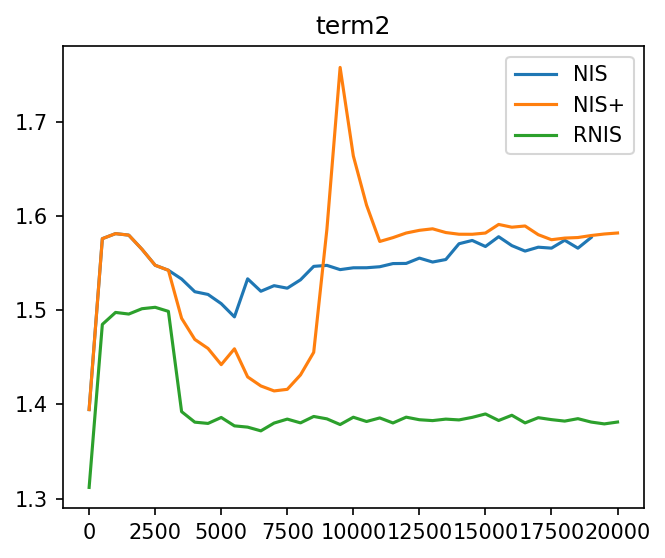

In [12]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, term2s_nis, label='NIS')
timeseries = np.arange(len(term1s_nisp)) * clip
plt.plot(timeseries, term2s_nisp, label='NIS+')
timeseries = np.arange(len(term2s_rnis)) * clip
plt.plot(timeseries, term2s_rnis, label='RNIS')
plt.title(r'term2')
plt.legend()
# plt.yscale('log')
plt.show()

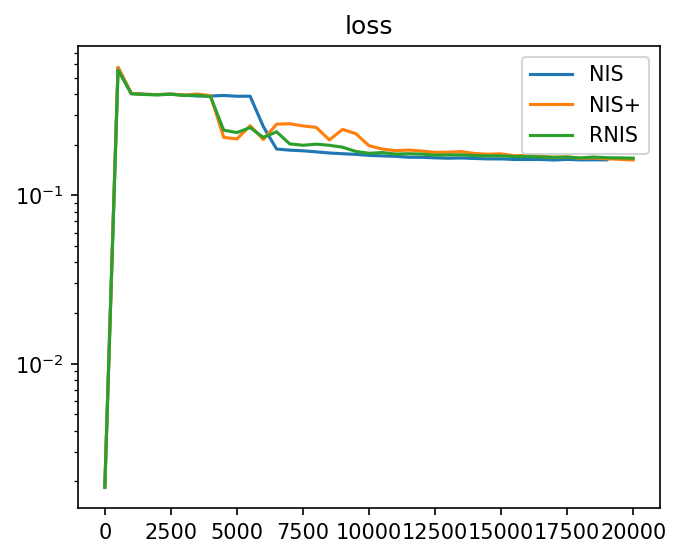

In [13]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, losses_nis, label='NIS')
timeseries = np.arange(len(losses_nisp)) * clip
plt.plot(timeseries, losses_nisp, label='NIS+')
timeseries = np.arange(len(losses_rnis)) * clip
plt.plot(timeseries, losses_rnis, label='RNIS')
plt.title(r'loss')
plt.legend()
plt.yscale('log')
plt.show()

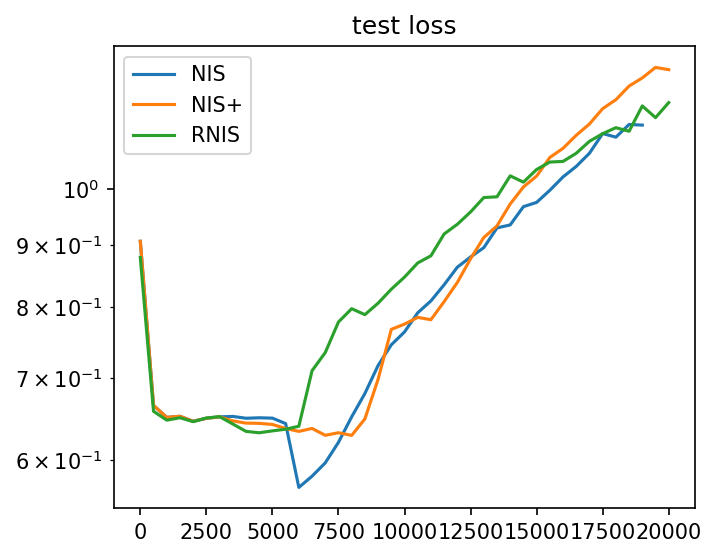

In [14]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis)) * clip
plt.plot(timeseries, MAEs_mstep_nis, label='NIS')
timeseries = np.arange(len(MAEs_mstep_nisp)) * clip
plt.plot(timeseries, MAEs_mstep_nisp, label='NIS+')
timeseries = np.arange(len(MAEs_mstep_rnis)) * clip
plt.plot(timeseries, MAEs_mstep_rnis, label='RNIS')
plt.title(r'test loss')
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
mae2_w